In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [2]:
#create a label column
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
traindf['label']=label    

label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
testdf['label']=label

In [3]:
X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

In [4]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 27, 
                                                  stratify=y)

In [5]:
df_train= pd.DataFrame(columns=['image_id','label'])
df_train['image_id'] = train_x
df_train['label'] = train_y

df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y

In [6]:
#uncomment according to the architecture being used
# IMG_SIZE = 224 #B0
# IMG_SIZE = 240 #B1
# IMG_SIZE = 260 #B2
IMG_SIZE = 300 #B3
# IMG_SIZE = 380 #B4
# IMG_SIZE = 456 #B5
# IMG_SIZE = 528 #B6
# IMG_SIZE = 600 #B7

In [7]:
train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                 #rescale=1./255.
                                )  

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            drop_duplicates = False,
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

valid_datagen=ImageDataGenerator()#rescale=1./255.)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=30,
                                                seed=40,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB3

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs

    # Create the base model from the pre-trained model EfficientNet
    base_model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = False
    
    # Rebuild top
    x=base_model.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)#(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #x = layers.Dense(1024)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

NUM_CLASSES=1
model = build_model(num_classes=NUM_CLASSES)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [9]:
#how this model performs on this data before fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

25/25 [==============================] - 95s 4s/step - loss: 0.8223 - accuracy: 0.2375


[0.8223003149032593, 0.23749999701976776]

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# simple early stopping
es_fe = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_fe = ModelCheckpoint('saved_model/best_basic_binaryclassf', monitor='val_loss', mode='max', verbose=1, save_best_only=True)

hist=model.fit(train_generator,
               epochs=12,
               validation_data=valid_generator,
               verbose=1,
               callbacks=[es_fe, mc_fe]
              )


Epoch 1/12
100/100 [==============================] - 533s 5s/step - loss: 0.5765 - accuracy: 0.7212 - val_loss: 0.4578 - val_accuracy: 0.8125
Epoch 2/12
100/100 [==============================] - 507s 5s/step - loss: 0.4876 - accuracy: 0.7919 - val_loss: 0.4488 - val_accuracy: 0.8125
Epoch 3/12
100/100 [==============================] - 516s 5s/step - loss: 0.4786 - accuracy: 0.8106 - val_loss: 0.4382 - val_accuracy: 0.8150
Epoch 4/12
100/100 [==============================] - 522s 5s/step - loss: 0.4473 - accuracy: 0.8119 - val_loss: 0.4378 - val_accuracy: 0.8100
Epoch 5/12
100/100 [==============================] - 499s 5s/step - loss: 0.4650 - accuracy: 0.7919 - val_loss: 0.4331 - val_accuracy: 0.8175
Epoch 6/12
100/100 [==============================] - 519s 5s/step - loss: 0.4376 - accuracy: 0.8156 - val_loss: 0.4329 - val_accuracy: 0.8175
Epoch 7/12
100/100 [==============================] - 501s 5s/step - loss: 0.4231 - accuracy: 0.8225 - val_loss: 0.4421 - val_accuracy: 0.7925

In [ ]:
# Save the entire model as a SavedModel.
model.save('saved_model/basic_binaryclassf_featureextr')

# load model
#new_model = tf.keras.models.load_model('saved_model/basic_binaryclassf_featureextr')
#model.summary()

In [11]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-18:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

for l in model.layers:
    print(l.name, l.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [12]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('saved_model/best_basic_binaryclassf', monitor='val_loss', mode='max', verbose=1, save_best_only=True)

hist=model.fit(train_generator,
               epochs=8,
               validation_data=valid_generator,
               verbose=1,
               callbacks=[es, mc]
              )


Epoch 1/8
100/100 [==============================] - 543s 5s/step - loss: 0.4290 - accuracy: 0.8181 - val_loss: 0.4290 - val_accuracy: 0.8375
Epoch 2/8
100/100 [==============================] - 552s 6s/step - loss: 0.4197 - accuracy: 0.8169 - val_loss: 0.4453 - val_accuracy: 0.8225
Epoch 3/8
100/100 [==============================] - 521s 5s/step - loss: 0.4085 - accuracy: 0.8231 - val_loss: 0.4477 - val_accuracy: 0.8250
Epoch 4/8
100/100 [==============================] - 523s 5s/step - loss: 0.3691 - accuracy: 0.8394 - val_loss: 0.4413 - val_accuracy: 0.8050
Epoch 5/8
100/100 [==============================] - 514s 5s/step - loss: 0.3655 - accuracy: 0.8381 - val_loss: 0.4803 - val_accuracy: 0.8125
Epoch 6/8
100/100 [==============================] - 520s 5s/step - loss: 0.3881 - accuracy: 0.8369 - val_loss: 0.4379 - val_accuracy: 0.8100
Epoch 7/8
100/100 [==============================] - 525s 5s/step - loss: 0.3578 - accuracy: 0.8537 - val_loss: 0.4288 - val_accuracy: 0.8075
Epoch 

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/basic_binaryclassf\assets


In [26]:
# load model
#new_model = tf.keras.models.load_model('saved_model/basic_binaryclassf')
#model.summary()

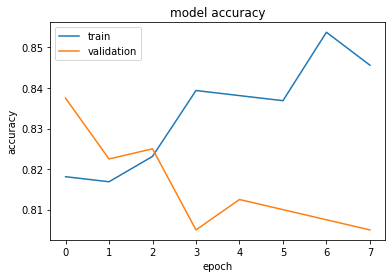

In [23]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

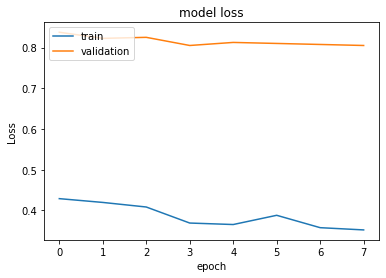

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_accuracy"])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [15]:
#how this model performs after fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

25/25 [==============================] - 99s 4s/step - loss: 0.4194 - accuracy: 0.8050


[0.4194403886795044, 0.8050000071525574]

In [16]:
test_generator.reset()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

20/20 [==============================] - 316s 16s/step


In [17]:
labels_pred=np.where(pred > 0.5, 1, 0)

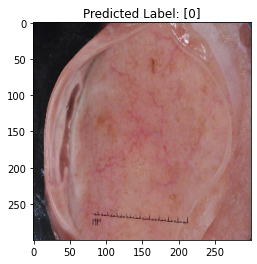

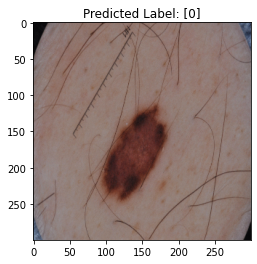

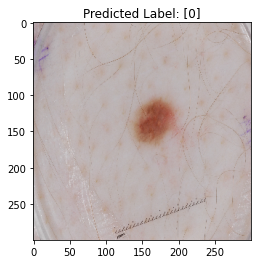

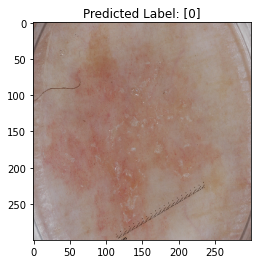

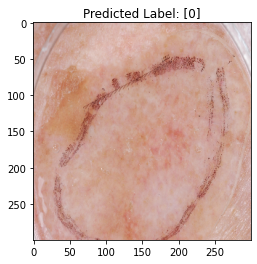

In [18]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(5):
    image = x[i]
    plt.title('Predicted Label: ' + str(labels_pred[i]))
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [19]:
import sklearn
acc=sklearn.metrics.accuracy_score(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Accuracy: \n' + str(acc))

Accuracy: 
0.8083333333333333


In [20]:
confusion_matrix=sklearn.metrics.confusion_matrix(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Confusion Matrix: \n' + str(confusion_matrix))

Confusion Matrix: 
[[448  35]
 [ 80  37]]


AUC Score: 0.6218877740616872


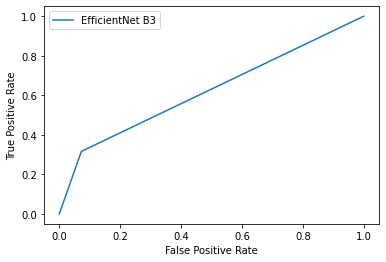

In [21]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(testdf['label'].astype(int).to_numpy(),labels_pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC Score: ' + str(roc_auc))

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='EfficientNet B3')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [22]:
jac=sklearn.metrics.jaccard_score(testdf['label'].astype(int).to_numpy(), labels_pred)
print('Jaccard Score: ' + str(jac))

Jaccard Score: 0.24342105263157895
